In [4]:
# SARIMAX example: for univariate time series with trend and/or seasonal components and exogenous variables.
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as smt
import seaborn as sns
import matplotlib.patches as mpatches
from statsmodels.graphics.tsaplots import plot_pacf , plot_acf
from statsmodels.tsa.ar_model import AR
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import numpy as np
from random import random
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

nupic 1.0.6.dev0 requires asteval==0.9.1, which is not installed.
nupic 1.0.6.dev0 requires coverage==3.7.1, which is not installed.
nupic 1.0.6.dev0 requires DBUtils==1.1, which is not installed.
nupic 1.0.6.dev0 requires nupic.bindings==1.0.6, which is not installed.
nupic 1.0.6.dev0 requires ordereddict==1.1, which is not installed.
nupic 1.0.6.dev0 requires prettytable==0.7.2, which is not installed.
nupic 1.0.6.dev0 requires PyMySQL==0.6.2, which is not installed.
nupic 1.0.6.dev0 requires pyproj==1.9.3, which is not installed.
nupic 1.0.6.dev0 requires pytest-cov==2.5.0, which is not installed.
nupic 1.0.6.dev0 requires pytest-xdist==1.16.0, which is not installed.
nupic 1.0.6.dev0 requires unittest2==0.5.1, which is not installed.
nupic 1.0.6.dev0 requires validictory==0.9.1, which is not installed.
nupic 1.0.6.dev0 has requirement mock==1.0.1, but you'll have mock 2.0.0 which is incompatible.
nupic 1.0.6.dev0 has requirement numpy==1.12.1, but you'll have numpy 1.14.5 which is 

In [3]:
#file locations
src_path ="C:\\Users\\RJO7ABT\\Documents\\Bosch-MT\\Daten\\csv\\DEMAGNET_MAX_SPEED_FILT.csv"
df_demag = pd.read_csv(src_path)

## 1. Data Exploration


Five Point Summary
       IPB.TEMP.BULKHEAD  IPB.TEMP.BAG  DEMAGNET_MAX_SPEED_FILT
count       42708.000000  42708.000000             42708.000000
mean           68.462491     66.657526                12.721800
std            36.613943     35.406429                 6.363984
min           -39.288330    -36.730957               -10.568316
25%            61.358643     59.552002                 9.438804
50%            81.323242     79.028320                13.108917
75%           104.071045    101.301575                17.422619
max           107.751465    104.852295                65.670861


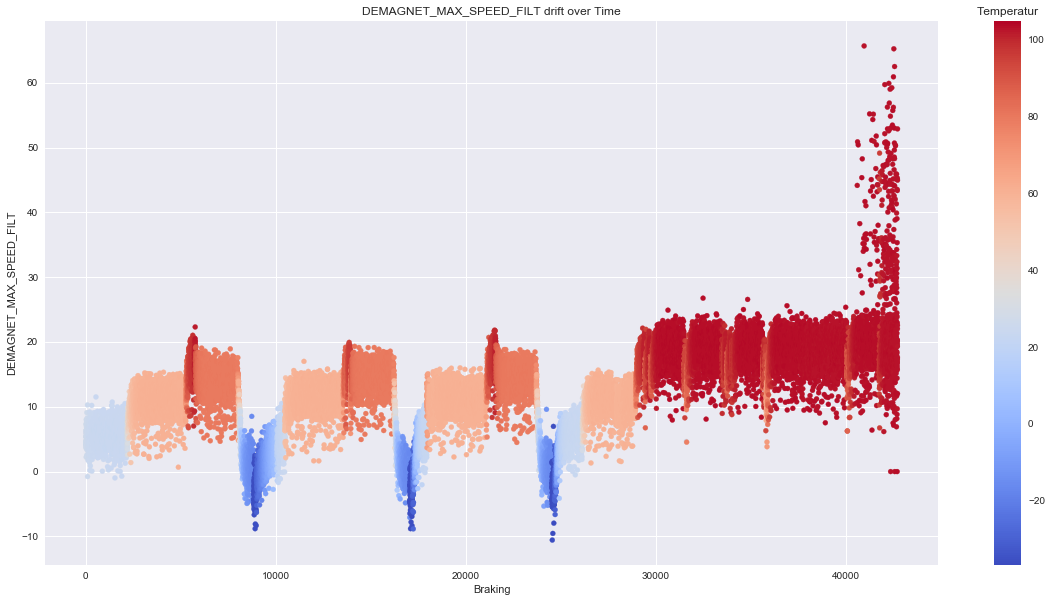

In [4]:
#data preperation and exploration
df = pd.read_csv(src_path)

#create ID and change Index to DATE
if True:
    df["ID"] = df.index + 1
    
#set convert to True to convert datetime object column to string
if True:
    df['DATE'] = df['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    

print("Five Point Summary")
print(df.iloc[:,0:-1].describe())

    
df.index=pd.to_datetime(df['DATE'])


fig, ax = plt.subplots(figsize=(20,10))
scatter = ax.scatter(df['ID'].tolist(), y=df['DEMAGNET_MAX_SPEED_FILT'] , c=df['IPB.TEMP.BAG'], s=100, marker='.', cmap=plt.cm.coolwarm)
clb = fig.colorbar(scatter)
clb.ax.set_title('Temperatur')
plt.xlabel("Braking")
plt.ylabel("DEMAGNET_MAX_SPEED_FILT")
plt.title("DEMAGNET_MAX_SPEED_FILT drift over Time")
plt.show()


#convert univariate dataframe to list
demag_list = df['DEMAGNET_MAX_SPEED_FILT'].tolist()

if type(df) == list:
    print(type(demag_list))
    
#type(demag_list)

## 2. LSTM

In [15]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

ModuleNotFoundError: No module named 'keras'

In [7]:
# split a univariate sequence into samples
def data_preparation(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [14]:
X3 , y1 = data_preparation(demag_list, 3)
print(len(X3), len(y1))

42705 42705


In [8]:
#naive and average baseline
def baseline(data, setting):
    window, types = setting
    value_list = list()
    
    if types == 'naive':
        #naive/persistence baseline
        return data[-1]
    
    
    else:
        if window == 1:
            value_list = data[-window]
            #print(value_list)
    
        else:
            #print("average baseline")
            for i in range(1, window+1):
                #if i > 0:
                    #print(data[-i])
                    value_list.append(data[-i])
    
        return np.mean(value_list)

In [9]:
#make naive and average baseline forecast
def baseline_forecast(data, window=2):
    naive_forecast_list = []
    average_forecast_list = []

    for i in range(0, len(data)):
        #print("----- value %d ------ " % i)
        if i > 0:
            #print("naive forecast: " + str(baseline(data[0:i], (1,'naive'))))
            naive_forecast_list.append(baseline(data[0:i], (1,'naive')))
        else:
            #print('naive forecast: NAN' )
            naive_forecast_list.append(np.nan)
            #pass
    
        if i >= window:
            #print("average forecast: " + str(baseline(data[0:i], (window,'average'))))
            average_forecast_list.append(baseline(data[0:i], (window,'average')))
        else:
            #print('average forecast: NAN' )
            average_forecast_list.append(np.nan)
            #pass
    
        #print("actual: " + str(data[i]))

    return naive_forecast_list, average_forecast_list

In [10]:
#make naive and average baseline forecast
window_size=2
naive_forecast_list, average_forecast_list = baseline_forecast(demag_list, window_size)

In [11]:
#evaluation metrics
def mse(actual, predicted):
    return  mean_squared_error(actual, predicted)

def rmse(mse):
    return np.sqrt(mse)

In [108]:
#df_baseline_forecast = pd.DataFrame(
#    {'1_demag': demag_list,
#     '2_naive_forecast': naive_forecast_list,
#     '3_average_forecast': average_forecast_list
#    })#
#
#df_baseline_forecast_dropna=  df_baseline_forecast.dropna()


#naive_mse = mse(df_baseline_forecast_dropna['1_demag'],df_baseline_forecast_dropna['2_naive_forecast'])
#average_2_mse = mse(df_baseline_forecast_dropna['1_demag'],df_baseline_forecast_dropna['3_average_forecast'])

#naive_rmse = rmse(naive_mse)
#average_2_rmse = rmse(average_2_mse)
#
#
#
#print("Naive baseline forecast MSE: " + str(naive_mse))
#print("Average  baseline forecast (Window=3)  MSE: " + str(average_2_mse))

#print("Average baseline forecast RMSE: " + str(naive_rmse))
#print("Average  baseline forecast (Window=3)  RMSE: " + str(average_2_rmse))

In [65]:
# grid search for best baseline
def grid_search_baseline(data, window_size):
    
    df_rmse_baseline = pd.DataFrame(columns=['baseline' ,'MSE', 'RMSE'])
    
    for window in range(1, window_size+1):
        #print(window)
        if window == 1:
            _, average_forecast_list = baseline_forecast(data, window)
            df_baseline_forecast = pd.DataFrame({'demag': demag_list,
                                                 'naive_forecast': average_forecast_list,
                                                 })
            
            df_mse = df_baseline_forecast[['demag', 'naive_forecast']].dropna()
            
            mse_ = mse(df_mse['demag'],df_mse['naive_forecast'])
            rmse_ = rmse(mse_)
            print("naive_forecast MSE: " + str(mse_))
            df_rmse_baseline = df_rmse_baseline.append(pd.DataFrame([['naive_forecast', mse_, rmse_]], 
                                                                    columns=['baseline' ,'MSE', 'RMSE']),
                                                       ignore_index=True)
    
        else:
            _ , average_forecast_list = baseline_forecast(data, window)
            df_baseline_forecast['w%d_average_forecast' % window] = pd.Series(average_forecast_list)
            df_mse = df_baseline_forecast[['demag', 'w%d_average_forecast' % window]].dropna()
            print('w%d_average_forecast MSE: '  % window + str(mse(df_mse['demag'],df_mse['w%d_average_forecast' % window])))
            
            mse_ = mse(df_mse['demag'],df_mse['w%d_average_forecast' % window])
            rmse_ = rmse(mse_)
            df_rmse_baseline = df_rmse_baseline.append(pd.DataFrame([['w%d_average_forecast' % window, mse_, rmse_]], 
                                                                    columns=['baseline' ,'MSE', 'RMSE']),
                                                       ignore_index=True)
    
    return df_rmse_baseline
    
    

naive_forecast MSE: 12.5060891353
w2_average_forecast MSE: 9.28849309801
w3_average_forecast MSE: 8.33984325772
w4_average_forecast MSE: 7.85250946074
w5_average_forecast MSE: 7.54325652723
w6_average_forecast MSE: 7.34150033287
w7_average_forecast MSE: 7.1691816694
w8_average_forecast MSE: 7.02509252324
w9_average_forecast MSE: 6.92438430229
w10_average_forecast MSE: 6.85934066276
w11_average_forecast MSE: 6.80246862116
w12_average_forecast MSE: 6.75315488656
w13_average_forecast MSE: 6.69633949484
w14_average_forecast MSE: 6.67048145621
w15_average_forecast MSE: 6.62905109919
w16_average_forecast MSE: 6.60060745366
w17_average_forecast MSE: 6.595170365
w18_average_forecast MSE: 6.58940068346
w19_average_forecast MSE: 6.58555035224
w20_average_forecast MSE: 6.57464048089
w21_average_forecast MSE: 6.55486551607
w22_average_forecast MSE: 6.5467769912
w23_average_forecast MSE: 6.53302599982
w24_average_forecast MSE: 6.5305973811
w25_average_forecast MSE: 6.52119895081
w26_average_forecas

In [73]:
#df_rmse_baseline = grid_search_baseline(demag_list, 150)
print("best naive forecast model: ")
df_rmse_baseline[df_rmse_baseline['RMSE'] == np.min(df_rmse_baseline['RMSE'])]

best naive forecast model: 


,baseline,MSE,RMSE
41,w42_average_forecast,6.465111,2.542658


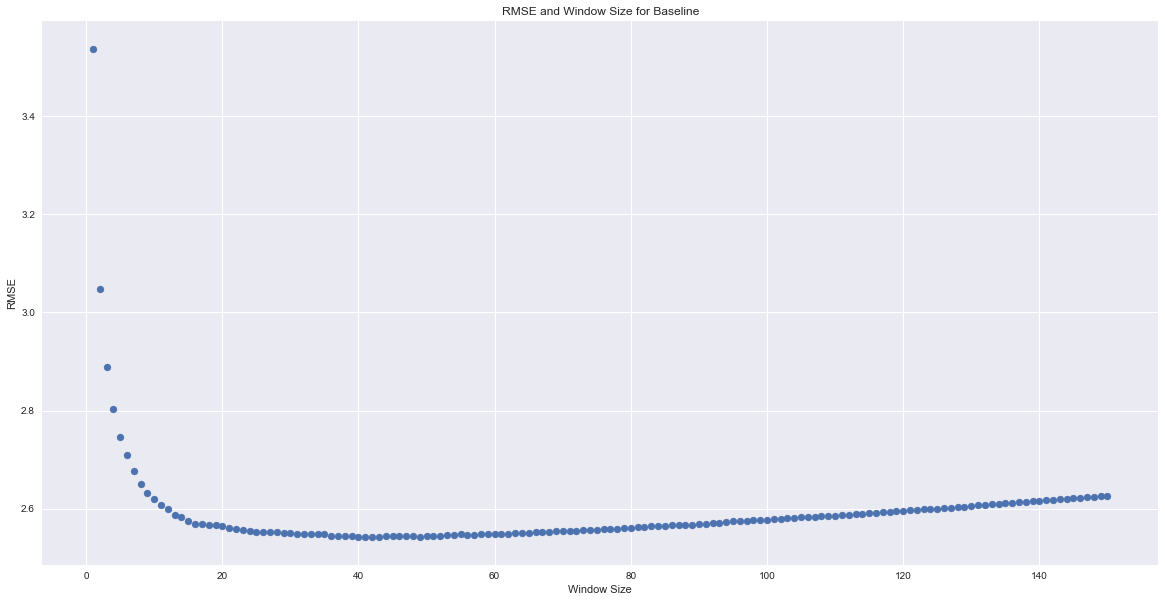

In [105]:
_, ax = plt.subplots(figsize=(20,10))
ax.scatter([x for x in range(1, len(df_rmse_baseline)+1)],df_rmse_baseline['RMSE'])
ax.set_xlabel("Window Size")
ax.set_ylabel("RMSE")
ax.set_title("RMSE and Window Size for Baseline")
plt.show()    

In [106]:
##train test split for forecasting
#start_split=0
#end_split=30000


#train_demag_list, test_demag_list = train_test_split(df_baseline_forecast_dropna, column='1_demag')
#train_naive_list, test_naive_list = train_test_split(df_baseline_forecast_dropna, column='2_naive_forecast')
#train_average_list, test_average_list = train_test_split(df_baseline_forecast_dropna, column='3_average_forecast')


#_, ax = plt.subplots(figsize=(20,10))
#ax.plot(train)
#ax.plot([None for i in range(end)] + [x for x in test_demag_list])
#ax.plot([None for i in range(end)] + [x for x in test_naive_list])
#ax.set_xlim([end-x_start ,end+x_end])
#ax.set_ylim([5,25])
#ax.set_xlabel("Brakings")
#ax.set_ylabel("DEMAGNET_MAX_SPEED_FILT")
#ax.set_title("Baseline naive Forecast/ Persistence Algorithm")
#plt.legend(handles=[green_patch, red_patch])
#plt.show()

Train: 
actual: [ 18.02929678  18.00978039  21.13344971]
Test: 
actual: [ 19.8349468   14.04515869  18.98061465  18.63944757  18.8636007 ]
predict: [ 21.13344971  19.8349468   14.04515869  18.98061465  18.63944757]
Residuals: 
[ 1.29850292  5.7897881  -4.93545595  0.34116707 -0.22415313]
Test MSE: 11.947
Test RMSE: 3.456


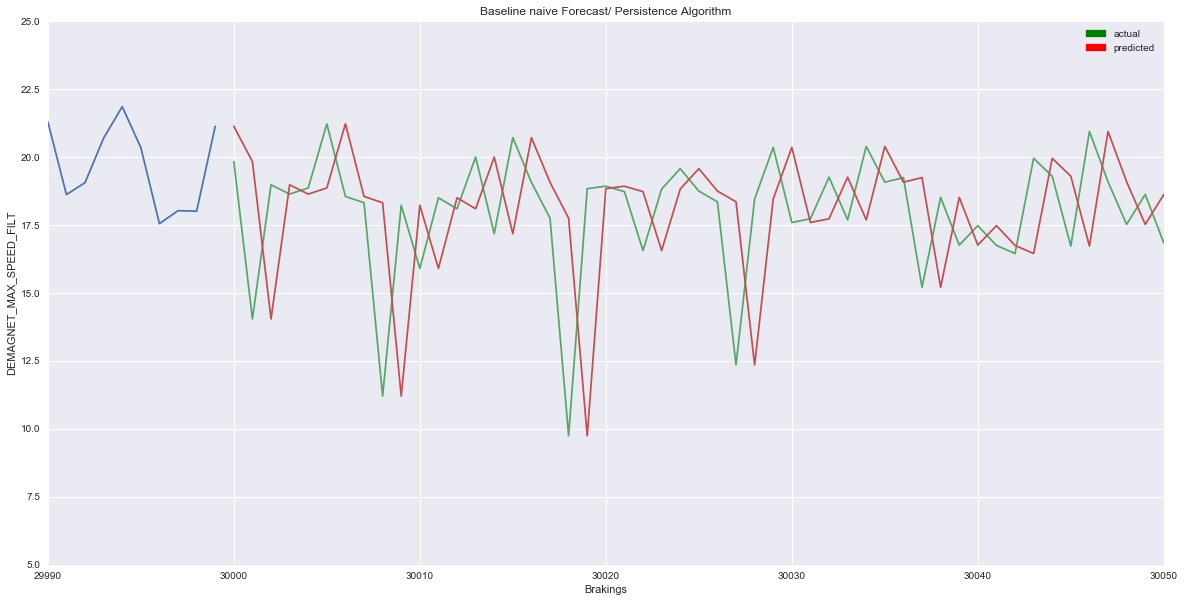

In [139]:
#Walk Foward Validation

start_plot = len(train_demag_list)-10
end_plot = 

#range of forecast prediction and actual values for naive forecast
def plot_baseline(train, test, predictions, start=0, end=10, x_start=10, x_end=50):
    
    red_patch = mpatches.Patch(color='red', label='predicted')
    green_patch = mpatches.Patch(color='green', label='actual')
    
    _, ax = plt.subplots(figsize=(20,10))
    ax.plot(train)
    ax.plot([None for i in range(end)] + [x for x in test])
    ax.plot([None for i in range(end)] + [x for x in predictions])
    ax.set_xlim([end-x_start ,end+x_end])
    ax.set_ylim([5,25])
    ax.set_xlabel("Brakings")
    ax.set_ylabel("DEMAGNET_MAX_SPEED_FILT")
    ax.set_title("Baseline naive Forecast/ Persistence Algorithm")
    plt.legend(handles=[green_patch, red_patch])
    plt.show()

#plot residuals of Baseline Model
def plot_residual(test_X, test_Y):
    _, ax = plt.subplots(figsize=(20,10))
    ax.plot(test_X - test_Y )
    #ax.set_xlim([train_size-20 ,train_size+100])
    ax.set_xlim([end-x_start ,end+x_end])
    ax.set_xlabel("Brakings")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals of Baseline naive Forecast")
    #plt.legend(handles=blue_patch)
    plt.show()  
    
    
    
plot_baseline(train_demag_list, test_demag_list, test_naive_list, start=start, end=end)
plot_baseline(train_actual, test_actual, , start=start, end=end)

## 3. SARIMA

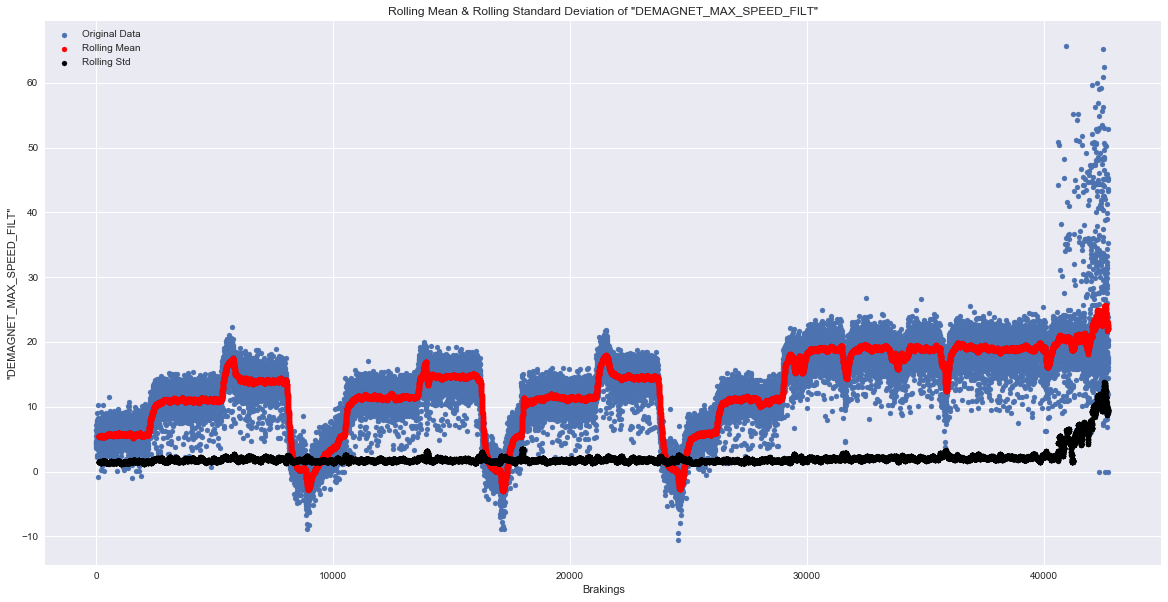

In [111]:
def plot_stationarity(xaxis, yaxis):
    
    _, ax = plt.subplots(figsize=(20,10))
    ax.scatter(y=yaxis, x=xaxis , s=100, marker='.',label = 'Original Data')
    ax.scatter(x=xaxis, y=yaxis.rolling(window = 100, center = False).mean(), s=100, marker='.', color = 'red', label = 'Rolling Mean')
    ax.scatter(x=xaxis, y=yaxis.rolling(window = 100, center = False).std(), s=100, marker='.', color = 'black', label = 'Rolling Std')
    
    
    plt.xlabel('Brakings')
    plt.ylabel('"DEMAGNET_MAX_SPEED_FILT"')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Rolling Standard Deviation of "DEMAGNET_MAX_SPEED_FILT"')
    plt.show()
    
plot_stationarity(xaxis=df['ID'],yaxis=df['DEMAGNET_MAX_SPEED_FILT'])


In [109]:
def adfuller_test(ts, sig = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= sig:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['DEMAGNET_MAX_SPEED_FILT'], sig = 0.1)

Test Statistic                    -1.876453
p-value                            0.343218
#Lags Used                        55.000000
Number of Observations Used    42652.000000
Critical Value (1%)               -3.430503
Critical Value (5%)               -2.861608
Critical Value (10%)              -2.566806
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [115]:
#split data in train and test split
def train_test_split(data, n_train):
    
        #data = data[column].tolist() 
        
        if len(data) < n_train:
            raise Exception('end out of range: %d %d' % (end, len(data)))
        else:
            return data[0:n_train], data[n_train:]

In [231]:
# create a set of sarima configs to try
def sarima_config():
    parameter_list = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [1, 2]
    m_params = [0]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    param = [(p,d,q), (P,D,Q,m), t]
                                    parameter_list.append(param)
                                    
    return parameter_list

In [ ]:
train, test = train_test_split(demag_list,30000 )
#len(train)
#len(test)
#train_size=30000
#params = []
#walk_forward_validation(demag_list, train_size, params)
params = sarima_config()
#print(params[4])
#print(len(params))
print(test[0])
for i in range(0,len(params)):
    try:
        sarima_forecast(train, params[i])
        print(params[i])
    except ValueError:
        print("invalid model parameter setting")


21.1334497142
[ 7.75001957]
[(0, 0, 0), (0, 0, 1, 0), 'n']
[ 12.26584679]
[(0, 0, 0), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.76079748]
[(0, 0, 0), (1, 0, 1, 0), 'n']
[ 18.78545304]
[(0, 0, 0), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.78396678]
[(0, 0, 0), (2, 0, 1, 0), 'n']
[ 18.76370828]
[(0, 0, 0), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 12.88651061]
[(0, 0, 0), (0, 0, 1, 0), 'c']
[ 14.6743376]
[(0, 0, 0), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.73690687]
[(0, 0, 0), (1, 0, 1, 0), 'c']
[ 18.7621962]
[(0, 0, 0), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.58081022]
[(0, 0, 0), (2, 0, 1, 0), 'c']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.75490472]
[(0, 0, 0), (2, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.16771075]
[(0, 0, 0), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.38684299]
[(0, 0, 0), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.75563223]
[(0, 0, 0), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.50050233]
[(0, 0, 0), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.59987504]
[(0, 0, 0), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.93736773]
[(0, 0, 0), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 12.82605093]
[(0, 0, 0), (0, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 13.25553924]
[(0, 0, 0), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 14.00842366]
[(0, 0, 0), (1, 0, 1, 0), 'ct']
[ 14.94416849]
[(0, 0, 0), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 14.70632426]
[(0, 0, 0), (2, 0, 1, 0), 'ct']
[ 15.11243174]
[(0, 0, 0), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 9.81531006]
[(0, 0, 1), (0, 0, 1, 0), 'n']
[ 14.32312452]
[(0, 0, 1), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.01516821]
[(0, 0, 1), (1, 0, 1, 0), 'n']
[ 18.95242775]
[(0, 0, 1), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.78650569]
[(0, 0, 1), (2, 0, 1, 0), 'n']
[ 18.80440383]
[(0, 0, 1), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 13.58941575]
[(0, 0, 1), (0, 0, 1, 0), 'c']
[ 15.52738359]
[(0, 0, 1), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.76216228]
[(0, 0, 1), (1, 0, 1, 0), 'c']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.75039695]
[(0, 0, 1), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.73543143]
[(0, 0, 1), (2, 0, 1, 0), 'c']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.70571898]
[(0, 0, 1), (2, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 16.31917002]
[(0, 0, 1), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.57189311]
[(0, 0, 1), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting
[ 18.85693523]
[(0, 0, 1), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.42736147]
[(0, 0, 1), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.63308095]
[(0, 0, 1), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.91357327]
[(0, 0, 1), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 13.09968638]
[(0, 0, 1), (0, 0, 1, 0), 'ct']
[ 13.53434297]
[(0, 0, 1), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 13.96294426]
[(0, 0, 1), (1, 0, 1, 0), 'ct']
[ 15.6982837]
[(0, 0, 1), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 13.62469968]
[(0, 0, 1), (2, 0, 1, 0), 'ct']
[ 15.38982788]
[(0, 0, 1), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 14.32314333]
[(0, 0, 2), (0, 0, 1, 0), 'n']
[ 13.71708871]
[(0, 0, 2), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.81084609]
[(0, 0, 2), (1, 0, 1, 0), 'n']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.05129221]
[(0, 0, 2), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.82426612]
[(0, 0, 2), (2, 0, 1, 0), 'n']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.81114484]
[(0, 0, 2), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 15.52721805]
[(0, 0, 2), (0, 0, 1, 0), 'c']
[ 14.51101865]
[(0, 0, 2), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.76610355]
[(0, 0, 2), (1, 0, 1, 0), 'c']
[ 18.85673967]
[(0, 0, 2), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.77331476]
[(0, 0, 2), (2, 0, 1, 0), 'c']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.95279626]
[(0, 0, 2), (2, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.4052926]
[(0, 0, 2), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.62671577]
[(0, 0, 2), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.8401537]
[(0, 0, 2), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.40359847]
[(0, 0, 2), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting
[ 18.63507836]
[(0, 0, 2), (2, 0, 1, 0), 't']
[ 19.0010062]
[(0, 0, 2), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 13.19238957]
[(0, 0, 2), (0, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 13.60609715]
[(0, 0, 2), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 15.6873056]
[(0, 0, 2), (1, 0, 1, 0), 'ct']
[ 15.71656505]
[(0, 0, 2), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 14.8512459]
[(0, 0, 2), (2, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 15.66285047]
[(0, 0, 2), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 18.76123474]
[(0, 1, 0), (0, 0, 1, 0), 'n']
[ 18.78721917]
[(0, 1, 0), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.78565377]
[(0, 1, 0), (1, 0, 1, 0), 'n']
[ 18.76240682]
[(0, 1, 0), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.80753787]
[(0, 1, 0), (2, 0, 1, 0), 'n']
[ 18.77129729]
[(0, 1, 0), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.76890376]
[(0, 1, 0), (0, 0, 1, 0), 'c']
[ 18.79476425]
[(0, 1, 0), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.79326082]
[(0, 1, 0), (1, 0, 1, 0), 'c']
[ 18.77245854]
[(0, 1, 0), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.8150608]
[(0, 1, 0), (2, 0, 1, 0), 'c']
[ 18.77892127]
[(0, 1, 0), (2, 0, 2, 0), 'c']
invalid model para

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.8087996]
[(0, 1, 0), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.86177582]
[(0, 1, 0), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.80436866]
[(0, 1, 0), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.90100991]
[(0, 1, 0), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.80218857]
[(0, 1, 0), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.89807479]
[(0, 1, 0), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.80816866]
[(0, 1, 0), (0, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.86059995]
[(0, 1, 0), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.80375297]
[(0, 1, 0), (1, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.90047788]
[(0, 1, 0), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.801548]
[(0, 1, 0), (2, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.89753308]
[(0, 1, 0), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 19.19846637]
[(0, 1, 1), (0, 0, 1, 0), 'n']
[ 18.81243736]
[(0, 1, 1), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.77147626]
[(0, 1, 1), (1, 0, 1, 0), 'n']
[ 18.77228807]
[(0, 1, 1), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.77619138]
[(0, 1, 1), (2, 0, 1, 0), 'n']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.77494176]
[(0, 1, 1), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 19.20037682]
[(0, 1, 1), (0, 0, 1, 0), 'c']
[ 18.81994551]
[(0, 1, 1), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.78906044]
[(0, 1, 1), (1, 0, 1, 0), 'c']
[ 18.79359338]
[(0, 1, 1), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.78178445]
[(0, 1, 1), (2, 0, 1, 0), 'c']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.80026803]
[(0, 1, 1), (2, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 20.11948342]
[(0, 1, 1), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.41233234]
[(0, 1, 1), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 20.14514725]
[(0, 1, 1), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.63856758]
[(0, 1, 1), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 20.09762831]
[(0, 1, 1), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.61685454]
[(0, 1, 1), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 20.11524904]
[(0, 1, 1), (0, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.4044406]
[(0, 1, 1), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 20.14101516]
[(0, 1, 1), (1, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.634997]
[(0, 1, 1), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 20.09332932]
[(0, 1, 1), (2, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.61321897]
[(0, 1, 1), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 18.81243474]
[(0, 1, 2), (0, 0, 1, 0), 'n']
[ 19.45865675]
[(0, 1, 2), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.76961099]
[(0, 1, 2), (1, 0, 1, 0), 'n']
[ 18.82955093]
[(0, 1, 2), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.77109087]
[(0, 1, 2), (2, 0, 1, 0), 'n']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.80345919]
[(0, 1, 2), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.8198589]
[(0, 1, 2), (0, 0, 1, 0), 'c']
[ 19.462057]
[(0, 1, 2), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.78381884]
[(0, 1, 2), (1, 0, 1, 0), 'c']
[ 18.8309572]
[(0, 1, 2), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.77787715]
[(0, 1, 2), (2, 0, 1, 0), 'c']
[ 18.80114071]
[(0, 1, 2), (2, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.4107116]
[(0, 1, 2), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.39556856]
[(0, 1, 2), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.4479364]
[(0, 1, 2), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.6281116]
[(0, 1, 2), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.3900856]
[(0, 1, 2), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.60378117]
[(0, 1, 2), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.41227701]
[(0, 1, 2), (0, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.39848606]
[(0, 1, 2), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.44946398]
[(0, 1, 2), (1, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.62943161]
[(0, 1, 2), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.39167489]
[(0, 1, 2), (2, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.60512521]
[(0, 1, 2), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 18.76023704]
[(1, 0, 0), (0, 0, 1, 0), 'n']
[ 18.78541918]
[(1, 0, 0), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.78426097]
[(1, 0, 0), (1, 0, 1, 0), 'n']
[ 18.81383734]
[(1, 0, 0), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.78542504]
[(1, 0, 0), (2, 0, 1, 0), 'n']
[ 18.78477969]
[(1, 0, 0), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.73700536]
[(1, 0, 0), (0, 0, 1, 0), 'c']
[ 18.76219533]
[(1, 0, 0), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.76164805]
[(1, 0, 0), (1, 0, 1, 0), 'c']
[ 18.79666199]
[(1, 0, 0), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.78253055]
[(1, 0, 0), (2, 0, 1, 0), 'c']
[ 18.758153]
[(1, 0, 0), (2, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.75793945]
[(1, 0, 0), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.21973855]
[(1, 0, 0), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.30830818]
[(1, 0, 0), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.97266153]
[(1, 0, 0), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.31404306]
[(1, 0, 0), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.45891658]
[(1, 0, 0), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.27045543]
[(1, 0, 0), (0, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.74395623]
[(1, 0, 0), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 15.74074424]
[(1, 0, 0), (1, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.46127625]
[(1, 0, 0), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 15.79136463]
[(1, 0, 0), (2, 0, 1, 0), 'ct']
[ 15.9973856]
[(1, 0, 0), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 18.78541985]
[(1, 0, 1), (0, 0, 1, 0), 'n']
[ 18.81042597]
[(1, 0, 1), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.86768399]
[(1, 0, 1), (1, 0, 1, 0), 'n']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.76604793]
[(1, 0, 1), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.76612291]
[(1, 0, 1), (2, 0, 1, 0), 'n']
[ 18.77033724]
[(1, 0, 1), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.76234262]
[(1, 0, 1), (0, 0, 1, 0), 'c']
[ 18.78834478]
[(1, 0, 1), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.76763402]
[(1, 0, 1), (1, 0, 1, 0), 'c']
[ 18.80298486]
[(1, 0, 1), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.75265633]
[(1, 0, 1), (2, 0, 1, 0), 'c']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.79582944]
[(1, 0, 1), (2, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.27122485]
[(1, 0, 1), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.37124185]
[(1, 0, 1), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.56412091]
[(1, 0, 1), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 15.56788781]
[(1, 0, 1), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.58116005]
[(1, 0, 1), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.06680281]
[(1, 0, 1), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting
[ 17.72067279]
[(1, 0, 1), (0, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.85727038]
[(1, 0, 1), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 14.96707696]
[(1, 0, 1), (1, 0, 1, 0), 'ct']
[ 12.20362765]
[(1, 0, 1), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 15.02969873]
[(1, 0, 1), (2, 0, 1, 0), 'ct']
[ 15.55333302]
[(1, 0, 1), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 18.78757778]
[(1, 0, 2), (0, 0, 1, 0), 'n']
[ 18.80858267]
[(1, 0, 2), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.86121108]
[(1, 0, 2), (1, 0, 1, 0), 'n']
[ 18.87912034]
[(1, 0, 2), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.85930159]
[(1, 0, 2), (2, 0, 1, 0), 'n']
[ 18.76445021]
[(1, 0, 2), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.76462994]
[(1, 0, 2), (0, 0, 1, 0), 'c']
[ 18.78527496]
[(1, 0, 2), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.80701343]
[(1, 0, 2), (1, 0, 1, 0), 'c']
[ 18.78999229]
[(1, 0, 2), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.81402175]
[(1, 0, 2), (2, 0, 1, 0), 'c']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.78879105]
[(1, 0, 2), (2, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.39010833]
[(1, 0, 2), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 18.48752757]
[(1, 0, 2), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 15.61705551]
[(1, 0, 2), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 13.02481148]
[(1, 0, 2), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 15.6756924]
[(1, 0, 2), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 16.19287004]
[(1, 0, 2), (2, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.72933673]
[(1, 0, 2), (0, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 17.86836992]
[(1, 0, 2), (0, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 13.74957198]
[(1, 0, 2), (1, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 9.12790656]
[(1, 0, 2), (1, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 13.86049177]
[(1, 0, 2), (2, 0, 1, 0), 'ct']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 14.43144383]
[(1, 0, 2), (2, 0, 2, 0), 'ct']
invalid model parameter setting
invalid model parameter setting
[ 18.78565295]
[(1, 1, 0), (0, 0, 1, 0), 'n']
[ 18.77781827]
[(1, 1, 0), (0, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.78602621]
[(1, 1, 0), (1, 0, 1, 0), 'n']
[ 18.77108993]
[(1, 1, 0), (1, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.85234885]
[(1, 1, 0), (2, 0, 1, 0), 'n']
[ 18.77187901]
[(1, 1, 0), (2, 0, 2, 0), 'n']
invalid model parameter setting
invalid model parameter setting
[ 18.79321835]
[(1, 1, 0), (0, 0, 1, 0), 'c']
[ 18.78538988]
[(1, 1, 0), (0, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.79357037]
[(1, 1, 0), (1, 0, 1, 0), 'c']
[ 18.79177931]
[(1, 1, 0), (1, 0, 2, 0), 'c']
invalid model parameter setting
invalid model parameter setting
[ 18.85664332]
[(1, 1, 0), (2, 0, 1, 0), 'c']
[ 18.79307597]
[(1, 1, 0), (2, 0, 2, 0), 'c']
invalid model par

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.34211027]
[(1, 1, 0), (0, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.35342456]
[(1, 1, 0), (0, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.33900415]
[(1, 1, 0), (1, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.43634013]
[(1, 1, 0), (1, 0, 2, 0), 't']
invalid model parameter setting
invalid model parameter setting


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[ 19.32642488]
[(1, 1, 0), (2, 0, 1, 0), 't']


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [249]:
def sarima_forecast(train, params):
    order, s_order, trend = params
    
    model = SARIMAX(train, order=order, seasonal_order=s_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    prediction = model_fit.predict(len(train), len(train))
    print(prediction)
    #return prediction

In [175]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_train, params):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_train)
    #print(len(train), len(test))
    # seed history with training dataset
    #history = [x for x in train]
    #print(type(history))
    # step over each time step in the test set
    #for i in range(0, len(test)):
         #fit model and make forecast for history
         
    prediction = sarima_forecast(train, params)
        # store forecast in list of predictions
    predictions.append(prediction)
        # add actual observation to history for the next loop
    #train.append(test[i])
        # estimate prediction error

    mse_ = mse(test, predictions)
    return rmse(mse_)

In [218]:
SARIMAX(train, order=(0, 0, 0), seasonal_order=(0, 0, 1, 0), trend='n',
        enforce_stationarity=False, enforce_invertibility=False)

In [181]:
train, test = train_test_split(demag_list, 30000)
params = sarima_config()
print(params[3])

sarima_forecast(train, params[3])

#walk_forward_validation(demag_list, train_size , params[3])

[(0, 0, 0), (0, 0, 0, 3), 'n']


ValueError: Number of states in statespace model must be a positive number.

In [107]:
#def plot_acf_pacf():
    
#    fig, ax1 = plt.subplots(figsize=(20,10))
#    fig = sm.graphics.tsa.plot_acf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
    
#    ax2 = fig.add_subplot(212)
#    fig = sm.graphics.tsa.plot_pacf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)
    
#plot_acf_pacf()

NameError: name 'mte_seasonal_first_difference' is not defined

In [111]:
df_demag['DEMAGNET_MAX_SPEED_FILT_t+1'] = df_demag['DEMAGNET_MAX_SPEED_FILT'].shift(-1)
df_persistence_model = df_demag[['DEMAGNET_MAX_SPEED_FILT','DEMAGNET_MAX_SPEED_FILT_t+1']]
#print(df_persistence_model.head(3))
#df_persistence_model.add(df_persistence_model.diff(axis=1).head(3)['DEMAGNET_MAX_SPEED_FILT_t+1'], axis='columns')
df_persistence_model['residual'] = df_persistence_model['DEMAGNET_MAX_SPEED_FILT_t+1'] - df_persistence_model['DEMAGNET_MAX_SPEED_FILT'] 
#df_persistence_model["residual**2"] = df_persistence_model['residual'] **2
df_persistence_model = df_persistence_model.dropna()
df_persistence_model.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,DEMAGNET_MAX_SPEED_FILT,DEMAGNET_MAX_SPEED_FILT_t+1,residual
0,3.683064,4.699998,1.016934
1,4.699998,4.750997,0.050999
2,4.750997,4.158429,-0.592568


## 1 Investigate Dataset

## Baseline Persistence Model

## SARIMA(X)

In [ ]:
model_sarimax = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_sarimax_fit = model_sarimax.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

In [144]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
len(data)
print(data[98:])

[99.15583173370597]


##### Residual Summary Statistic

In [13]:
#print(df_persistence_model['residual'].describe())

In [12]:
#_, ax = plt.subplots(figsize=(20,10))
#sns.distplot(df_persistence_model['residual'],bins=100, hist=True, kde=True,)
#ax.set_xlabel("Residuals")
#ax.set_ylabel("Density")
#ax.set_title("Frequency of Baseline naive Forecast Residuals")
#plt.show()

In [11]:
#QQplot of residuals
#sm.qqplot(df_persistence_model['residual'], stats.t, fit=True, line='45')
#plt.title("QQPLOT of Residuals")
#plt.show()

In [8]:
#autocorrelation and partial autocorrelation Plots
#plot_acf(df_persistence_model['residual'], lags=5)
#plot_pacf(df_persistence_model['residual'], lags=5)
#plt.show()

#### SARIMA(X)

In [10]:
#plot_acf(df_demag['DEMAGNET_MAX_SPEED_FILT'], lags=2000)

In [79]:
#AR Model
#df_ar_model = df_demag[['DEMAGNET_MAX_SPEED_FILT','DEMAGNET_MAX_SPEED_FILT_t+1']]
#df_ar_model['DEMAGNET_MAX_SPEED_FILT'] = df_persistence_model['DEMAGNET_MAX_SPEED_FILT']
#print(df_ar_model.iloc[train_size:-1,])

#train_size = int(len(df_ar_model) * 0.99)
#print("Train Size: " + str(train_size))
#train, test = df_ar_model.iloc[0:train_size], df_ar_model.iloc[train_size:-1,]

#print("Test Size: " + str(len(test)))
#print(len(df_ar_model['DEMAGNET_MAX_SPEED_FILT']))
#print("Train tail: " + str(train.tail(5)))
#print("Test tail: " + str(test.head(5)))

start_ar, end_ar = (0, 10000)
train_ar = df_persistence_model.iloc[start_ar:end_ar,0]
print(train_ar.tail(1))
test_ar = df_persistence_model.iloc[end_ar:end_ar,0]
#, _ = df_persistence_model.iloc[end:,0], df_persistence_model.iloc[end:,1]

#print(train_ar_X[5000:5500].head(3))

model_ar = AR(np.asarray(train_ar))
model_fit = model_ar.fit()
print('Lag: %s' % model_fit.k_ar)
#print('Coefficients: %s' % model_fit.params)
# make predictions
predictions_ar = model_fit.predict(start=5000, end=5001, dynamic=False)
arr_actual_ar = np.asarray(train_ar_X[5002:5500])
print("actual: " + str(arr_actual_ar[0:5]))
print("predicted: " + str(predictions_ar[0:5]))
print(arr_test[0:5] - predictions[0:5])


print("AR")
for i in range(2):
    print('predicted=%f, expected=%f' % (predictions_ar[i], arr_actual[i]))


df_persistence_model.iloc[end:end+5,]


9999    2.066706
Name: DEMAGNET_MAX_SPEED_FILT, dtype: float64
Lag: 38
actual: [ 14.5306025   17.27798974  18.83385242  20.99062897  20.53748843]
predicted: [ 10.84750188  10.77008597]
[-1.3404994   1.91912751 -5.00130207 -2.18713842 -0.6436139 ]
AR
predicted=10.847502, expected=18.173298
predicted=10.770086, expected=21.164348


,DEMAGNET_MAX_SPEED_FILT,DEMAGNET_MAX_SPEED_FILT_t+1,residual
35000,18.173298,21.164348,2.991050
35001,21.164348,14.530602,-6.633745
35002,14.530602,17.277990,2.747387
35003,17.277990,18.833852,1.555863
35004,18.833852,20.990629,2.156777


In [34]:
'''
print("AR")
for i in range(10):
    print('predicted=%f, expected=%f' % (predictions[i], arr_test[i]))


print("base")    
arr_test_y=np.asarray(test_y)
for i in range(10):
    print('predicted=%f, expected=%f' % (predictions[i], arr_test_y[i]))

    
  
#Baseline MSE and RSME for 5 Steps
mse_base = mean_squared_error(test_y[0:10], predictions[0:10])
rmse_base = np.sqrt(mse_base)
print('Base MSE: %.3f' % mse_base)
print('Base RMSE: %.3f' % rmse_base)


#AR MSE and RMSE for 5 steps
mse_ar = mean_squared_error(arr_test[0:5], predictions[0:5])
rmse_ar = np.sqrt(mse_ar)
print('AR MSE: %.3f' % mse_ar)
print('AR RMSE: %.3f' % rmse_ar)

#plot results
#plt.plot(arr_de_mag_test)
#plt.plot(predictions, color='red')
#plt.show()

_, ax = plt.subplots(figsize=(20,10))
#ax.plot(train_y)
#ax.plot([None for i in train_y] + [x for x in arr_de_mag_test])
#ax.plot([None for i in train_y] + [x for x in predictions])
#ax.set_xlim([train_size-20 ,train_size+100])
#ax.set_xlabel("Brakings")
#ax.set_ylabel("DEMAGNET_MAX_SPEED_FILT")
#ax.set_title("Baseline naive Forecast/ Persistence Algorithm")
#plt.legend(handles=[green_patch, red_patch])
#plt.show()
'''

(12707,)
Lag: 32


ValueError: end is before start

In [66]:
#set convert to True to convert datetime object column to string
convert = False
if convert == True:
    df_demag['DATE'] = df_demag['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    
df_demag.info()

print(" ")
print("Five Point Summary")
df_demag.describe()


#create ID and change Index to DATE
index = False
if index == True:
    df_demag["id"] = float(df_demag.index) + 1

#df_demag["id"] = df_demag["id"].astype(float)
    
df_demag.index=pd.to_datetime(df_demag['DATE'])
df_demag.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42708 entries, 2018-04-13 15:33:41 to 2018-05-03 06:51:43
Data columns (total 5 columns):
IPB.TEMP.BULKHEAD          42708 non-null float64
IPB.TEMP.BAG               42708 non-null float64
DEMAGNET_MAX_SPEED_FILT    42708 non-null float64
DATE                       42708 non-null datetime64[ns]
id                         42708 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB
 
Five Point Summary


,IPB.TEMP.BULKHEAD,IPB.TEMP.BAG,DEMAGNET_MAX_SPEED_FILT,DATE,id
DATE,,,,,
2018-04-13 15:33:41,27.612305,26.977539,3.683064,2018-04-13 15:33:41,1.0
2018-04-13 15:34:10,27.349854,26.977539,4.699998,2018-04-13 15:34:10,2.0
2018-04-13 15:34:15,27.349854,26.910400,4.750997,2018-04-13 15:34:15,3.0


In [154]:
fig, ax = plt.subplots(figsize=(20,10))
scatter = ax.scatter(df_demag['id'].tolist(), y=df_demag['DEMAGNET_MAX_SPEED_FILT'] , c=df_demag['IPB.TEMP.BAG'], s=100, marker='.', cmap=plt.cm.coolwarm)
clb = fig.colorbar(scatter)
clb.ax.set_title('Temperatur')
plt.xlabel("Brake Amount")
plt.ylabel("DEMAGNET_MAX_SPEED_FILT")
plt.title("DEMAGNET_MAX_SPEED_FILT drift over Time")
#ax.set_xlim([datetime.date(2018, 4, 13), datetime.date(2018, 4, 23)])
plt.show()

KeyError: 'id'

In [94]:
def ts_plot(target, feature, title, lags=None, figsize=(12,8)):
    
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    #target.plot(ax=ts_ax)
    #ts_ax.scatter(df_demag['id'].tolist(), y=df_demag['DEMAGNET_MAX_SPEED_FILT'], marker='-')
    ts_ax.scatter(y=target, x=feature, marker='.', alpha=0.2)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    target.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.plot_acf(target, lags=lags, ax=acf_ax)
    smt.plot_pacf(target, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    #return ts_ax, acf_ax, pacf_ax

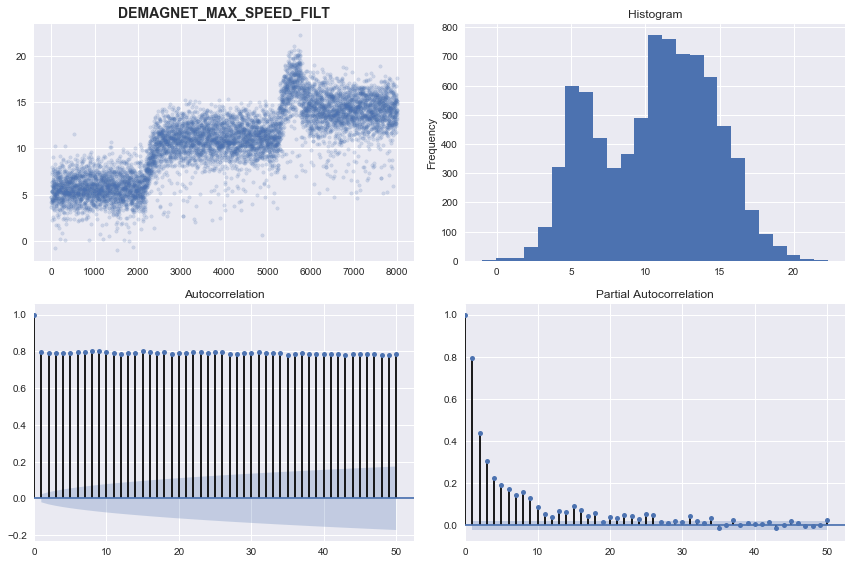

In [103]:
target= df_train['DEMAGNET_MAX_SPEED_FILT']
feature = df_train['id']

ts_plot(target=target,feature=feature ,title="DEMAGNET_MAX_SPEED_FILT", lags=50)
#ts_plot(target=df_train['IPB.TEMP.BAG'],feature=feature ,title="DEMAGNET_MAX_SPEED_FILT", lags=50)

In [107]:
X = df_demag['DEMAGNET_MAX_SPEED_FILT']
result = adfuller(X)
print('Adfuller Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Adfuller Statistic: -1.876453
p-value: 0.343218
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Null Hypotehsis (H0): If accepted, TS is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; TS is stationary.

p-value > 0.05: Accept H0, the data has a unit root and is non-stationary -> trend

p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary -> no trend

In [81]:
#target = df_demag["DEMAGNET_MAX_SPEED_FILT"]

end_train = 8000

#split train and test set
df_train = df_demag.iloc[0:end_train,:]
df_test = df_demag.iloc[end_train:,:]

#df_x_train = train_set.iloc[:,0:5]
#df_y_train = train_set.iloc[:,5:6]

#x_test = test_set.iloc[:,0:5]
#y_test = test_set.iloc[:,5:6]

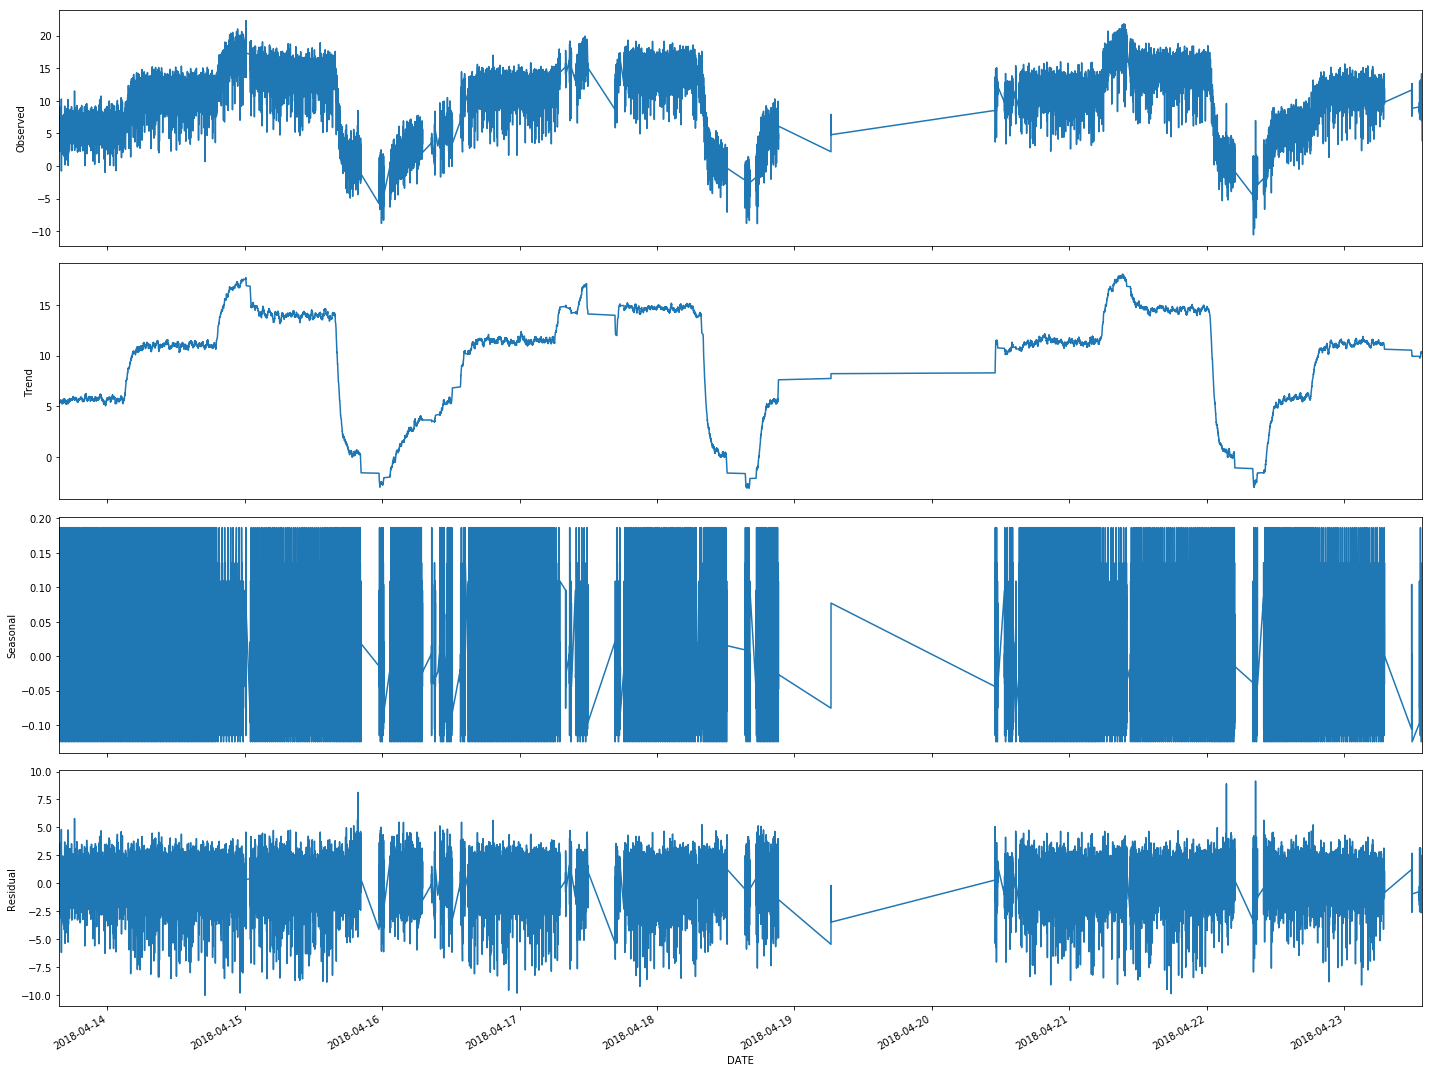

In [25]:
#fig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
#fig = sm.graphics.tsa.plot_acf(df_demag["DEMAGNET_MAX_SPEED_FILT"].diff().dropna(), lags=40, ax=ax1)
#ax2 = fig.add_subplot(212)
#fig = sm.graphics.tsa.plot_pacf(df_demag["DEMAGNET_MAX_SPEED_FILT"].diff().dropna(), lags=40, ax=ax2)
#plt.show()

from pylab import rcParams
rcParams['figure.figsize'] = 20, 15

decomposition = sm.tsa.seasonal_decompose(df_train["DEMAGNET_MAX_SPEED_FILT"], model='additive', freq=50)
fig = decomposition.plot()
plt.show()

                              Statespace Model Results                             
Dep. Variable:     DEMAGNET_MAX_SPEED_FILT   No. Observations:                28000
Model:                    SARIMAX(1, 1, 1)   Log Likelihood              -55482.357
Date:                     Mon, 13 Aug 2018   AIC                         110972.713
Time:                             17:08:48   BIC                         111005.673
Sample:                         04-13-2018   HQIC                        110983.324
                              - 04-23-2018                                         
Covariance Type:                       opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
IPB.TEMP.BAG     0.1480      0.002     81.241      0.000       0.144       0.152
ar.L1           -0.0154      0.006     -2.495      0.013      -0.028      -0.003
ma.L

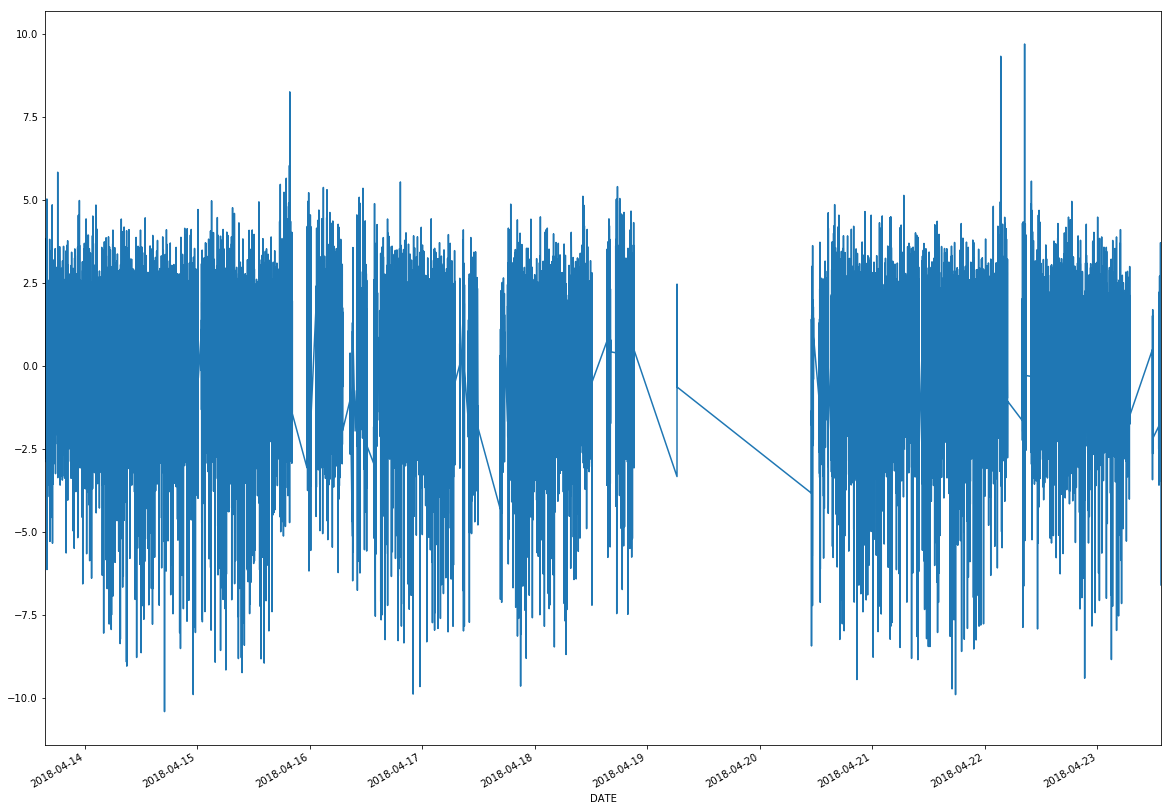

In [26]:
# fit model
model = SARIMAX(df_train['DEMAGNET_MAX_SPEED_FILT'], exog=df_train["IPB.TEMP.BAG"], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit( full_output=1, disp=5)
print(model_fit.summary())
#make prediction
#yhat = model_fit.predict(len(data1), len(data1), exog=[exog2])
#print(yhat)
model_fit.resid.plot()
plt.show()

In [23]:
#model = SARIMAX(df_train['DEMAGNET_MAX_SPEED_FILT'], exog=None, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
#model_fit = model.fit( full_output=1, disp=5)
#print(model_fit.summary())
#make prediction
#yhat = model_fit.predict(len(data1), len(data1), exog=[exog2])
#print(yhat)
#model_fit.resid.plot()
#plt.show()

In [ ]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train['DEMAGNET_MAX_SPEED_FILT'], exog=df_train["IPB.TEMP.BAG"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Holt Winter’s Exponential Smoothing (HWES)

In [ ]:
# HWES example


# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ExponentialSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

### LSTM

In [ ]:
# prepare univariate data for LSTM
def data_preparation(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)